# CatBoost

## Imports

In [1]:
import json
import yaml
import pandas as pd
import re
import numpy as np
import matplotlib.pyplot as plt
import time
import torch

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

## Database

In [2]:
df = pd.read_csv("database.csv")

In [3]:
df

,age,birth_date,civil_status,education_level,employer,firstname,link,lob,maiden_name,nationality,observation,occupation,surname,surname_household,household,sexe
0,25,NaN,Garçon,NaN,NaN,Cyrille,NaN,NaN,NaN,française,NaN,menuisier,Breton,NaN,0,1.0
1,30,NaN,Garçon,NaN,NaN,Auguste,NaN,NaN,NaN,Piémontaise,NaN,vitrier,NaN,Ferazzi,1,1.0
2,24,NaN,Garçon,NaN,NaN,Pierre,NaN,NaN,NaN,Piémontaise,NaN,vitrier,NaN,Machol,1,1.0
3,48,NaN,Homme marié,NaN,NaN,Alexandre,NaN,NaN,NaN,française,NaN,prop re,NaN,Desbois,1,1.0
4,30,NaN,NaN,NaN,NaN,Zélie,sa fe,NaN,NaN,française,NaN,prop re,Vignat,NaN,0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25069,NaN,1869,NaN,NaN,NaN,Marie,chef,Pailharès,NaN,française,NaN,NaN,NaN,Chameton-Dideron,1,NaN
25070,NaN,1863,NaN,NaN,Cara,Marie,chef,St Naz en Royans,NaN,française,NaN,ouv chaus res,NaN,Ode,1,NaN
25071,NaN,1886,NaN,NaN,Baretto,Nello,chef,Castel,NaN,italienne,NaN,manoeuvre,NaN,Berni,1,NaN
25072,NaN,1887,NaN,NaN,NaN,Annunziata,épouse,Castel,NaN,italienne,NaN,NaN,Berni-Laureti,NaN,0,NaN


In [4]:
df.replace(np.nan, -999,  inplace=True)

In [5]:
nan_counts = df.isna().sum()
nan_counts

age                  0
birth_date           0
civil_status         0
education_level      0
employer             0
firstname            0
link                 0
lob                  0
maiden_name          0
nationality          0
observation          0
occupation           0
surname              0
surname_household    0
household            0
sexe                 0
dtype: int64

## Model

In [6]:
X = df.drop(columns=['household','surname_household','surname','education_level','maiden_name'])
y = df["household"]

In [7]:
list_str_obj_cols = X.columns[X.dtypes == "object"].tolist()
for str_obj_col in list_str_obj_cols:
    X[str_obj_col] = X[str_obj_col].astype("category")

In [8]:
X.dtypes

age             category
birth_date      category
civil_status    category
employer        category
firstname       category
link            category
lob             category
nationality     category
observation     category
occupation      category
sexe             float64
dtype: object

In [9]:
categorical_features_names = X.select_dtypes(['category']).columns.tolist()

In [10]:
X[categorical_features_names].nunique()

age              358
birth_date       177
civil_status      13
employer        1086
firstname       2457
link             940
lob             2939
nationality       85
observation      308
occupation      2056
dtype: int64

In [11]:
X_train, X_test, y_train, y_test = train_test_split(
    X, 
    y,
    test_size=0.2, 
    random_state=12,
    shuffle=True
)

In [12]:
import catboost as cb

train_pool = cb.Pool(X_train, y_train, cat_features = categorical_features_names)
test_pool  = cb.Pool(X_test, y_test, cat_features = categorical_features_names)

In [13]:
start_time = time.time()
model = cb.CatBoostClassifier(verbose=False)
model.fit(train_pool, eval_set=test_pool, plot=True, use_best_model=True, early_stopping_rounds=20)
end_time = time.time()

training_time = end_time - start_time
print('Training time',training_time)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Training time 6.607566833496094


In [14]:
prediction = model.predict(test_pool)
fitted     = model.predict(train_pool)

In [15]:
print(classification_report(y_test, prediction))

              precision    recall  f1-score   support

           0       0.97      0.94      0.96      3914
           1       0.81      0.91      0.85      1101

    accuracy                           0.93      5015
   macro avg       0.89      0.92      0.91      5015
weighted avg       0.94      0.93      0.93      5015



/Users/ambreetienne/anaconda3/envs/env-torch/lib/python3.11/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/Users/ambreetienne/anaconda3/envs/env-torch/lib/python3.11/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/Users/ambreetienne/anaconda3/envs/env-torch/lib/python3.11/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/Users/ambreetienne/anaconda3/envs/env-torch/lib/python3.11/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed 

In [17]:
print(classification_report(fitted, y_train))

              precision    recall  f1-score   support

           0       0.96      0.99      0.97     15029
           1       0.96      0.86      0.91      5030

    accuracy                           0.96     20059
   macro avg       0.96      0.92      0.94     20059
weighted avg       0.96      0.96      0.95     20059



/Users/ambreetienne/anaconda3/envs/env-torch/lib/python3.11/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/Users/ambreetienne/anaconda3/envs/env-torch/lib/python3.11/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/Users/ambreetienne/anaconda3/envs/env-torch/lib/python3.11/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/Users/ambreetienne/anaconda3/envs/env-torch/lib/python3.11/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed 

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


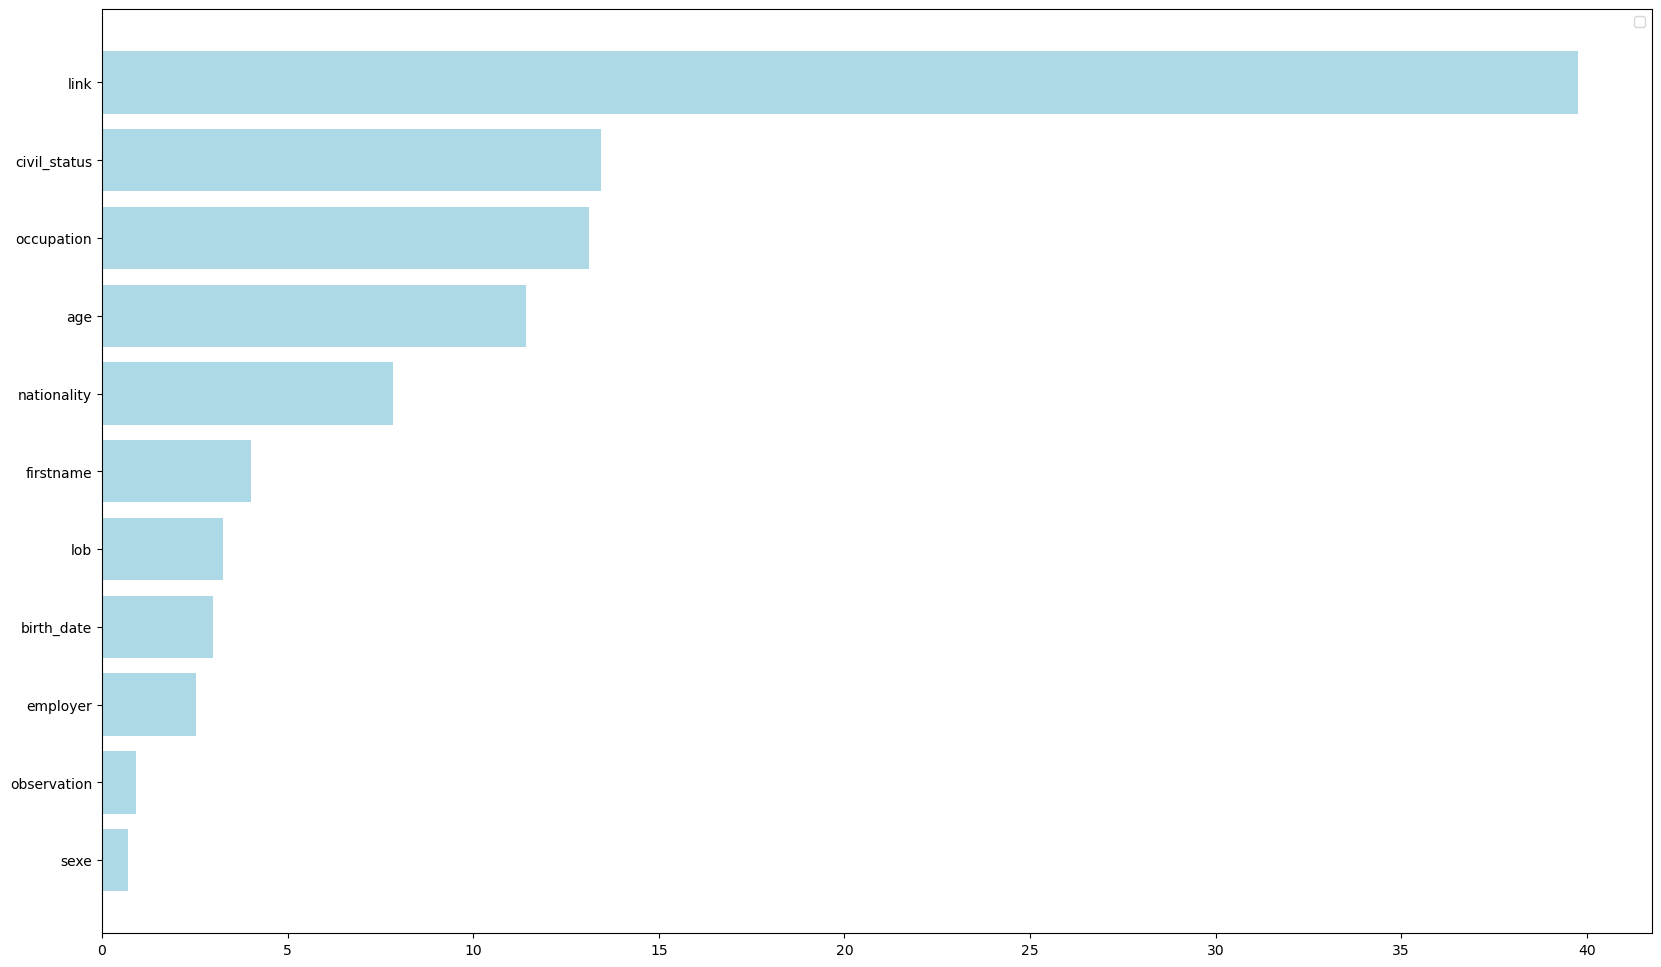

In [16]:
plt.figure(figsize=(20, 12))


sorted_feature_importance = model.feature_importances_.argsort()
plt.barh(X_test.columns[sorted_feature_importance], 
         model.feature_importances_[sorted_feature_importance], 
         color='lightblue')

# showing the plotting
plt.legend()
plt.show()